In [65]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed, Bidirectional, Input
from tensorflow.keras.models import Model, Sequential

import matplotlib.pyplot as plt

import numpy as np

from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

In [66]:
max_features = 10000 # Top 10,000 words
maxlen = 200 # First 200 words of each review

In [67]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = pad_sequences(X_train, maxlen=maxlen, padding="post")
X_test = pad_sequences(X_test, maxlen=maxlen, padding="post")

### NOTE
If you are using GPU, LSTM needs a tanh activation or it will not be compliant with cuDNN. This results in incredible slow training. CPU epochs were > 5 min while GPU epochs are < 30 seconds

In [75]:
embedding_dim = 8

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen)(input_layer)

encoded = LSTM(64, return_sequences=True)(embedding_layer)
decoded = TimeDistributed(Dense(max_features, activation='softmax'))(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 200, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 200, 64)        │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 200, 10000)     │       650,000 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,688 (2.86 MB)

 Trainable params: 748,688 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 249ms/step - loss: 7.4754 - val_loss: 5.4310
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - loss: 5.2230 - val_loss: 4.9424
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - loss: 4.8598 - val_loss: 4.6349
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - loss: 4.5364 - val_loss: 4.2574
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - loss: 4.1348 - val_loss: 3.8606
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - loss: 3.7253 - val_loss: 3.4643
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - loss: 3.3490 - val_loss: 3.0799
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - loss: 2.9640 - val_loss: 2.6845
Epoch 9/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - loss: 2.5729 - val_loss: 2.3316
Epoch 10/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - loss: 2.2359 - val_loss: 2.0428
Epoch 11/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - loss: 1.9671 - val_loss: 1.8018
Epoch 12/15
157/157

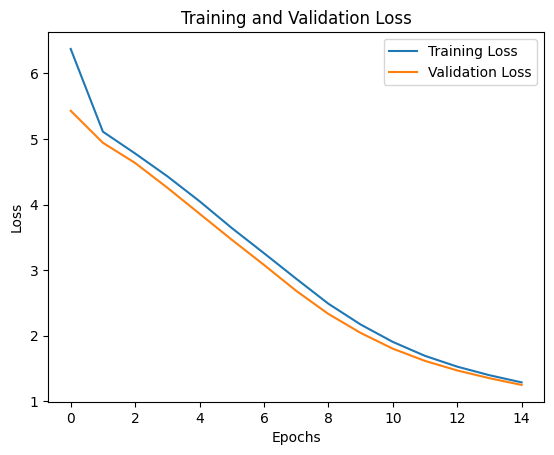

In [77]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [78]:
import random
# Display Original and Reconstructed Reviews
# Function to convert sequences to words using IMDb word index
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items()}

def sequence_to_text(sequence):
    return ' '.join([index_word.get(i - 3, '?') for i in sequence if i > 2])

n = 5  # Number of test reviews to show
x_test_rand = X_test[np.random.choice(X_test.shape[0], n, replace=False)]
reconstructions = autoencoder(x_test_rand)

# Display Original and Reconstructed Reviews
for i in range(len(reconstructions)):
    print("Original Review:")
    print(sequence_to_text(x_test_rand[i]))
    print("\nReconstructed Review:")
    print(sequence_to_text(np.argmax(reconstructions[i], axis=1)))
    print("\n" + "="*50 + "\n")

Original Review:
what can i say about twelve who thought that it would ever come to this a gigantic mess that loses itself halfway and can't i found myself amazed at how bad this really was really i have never seen the ending properly because this film is just i'm a huge fan of the first but this is a lame excuse for a sequel br br what was the point of the heist if they were going to give the money back the movie is just boring and so drag along that i can't ever sit through this it really is bad just stay as far repeat far away as possible from this movie it's worthless

Reconstructed Review:
what can i say about who thought that it would ever come to this a several that plan itself and can't i found myself let at how bad this really was really i have never seen the ending itself because this film is just i'm a 7 fan of the first but this is a none manages for a early br br what was the point of the if they were going to give the money back the movie is just boring and so student alo

In [79]:
len(reconstructions)

5

# Word2Vec instead of Keras Embedding Layer

In [8]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Decode all the reviews in both training and test data
train_data_text = [decode_review(review) for review in X_train]
test_data_text = [decode_review(review) for review in X_test]

In [9]:
print(len(train_data_text))
print(train_data_text[0])

25000
and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us al

In [10]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Convert text to lowercase
    return(tokens)
    
train_text_tokens = [preprocess_text(review) for review in train_data_text]
test_text_tokens = [preprocess_text(review) for review in test_data_text]

### Pretraining a Word2Vec model

In [11]:
word2vec_model = Word2Vec(train_text_tokens, vector_size=embedding_dim, window=5, min_count=3, workers=4, epochs=10)

# Prepare embedding matrix using Word2Vec vectors
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = word2vec_model.wv.get_vector(word) if word in word2vec_model.wv else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Inserting the word2vec model weights into the embedding layer
Here we set trainable=False because we have already trained the word2vec model above

In [12]:
embedding_dim = 4

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False)(input_layer)

encoded = LSTM(16, return_sequences=True)(embedding_layer)
decoded = TimeDistributed(Dense(max_features, activation='softmax'))(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

autoencoder.summary()

ValueError: Layer embedding_1 weight shape (10000, 4) is not compatible with provided weight shape (10000, 64).

In [ ]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

In [ ]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Display Original and Reconstructed Reviews
# Function to convert sequences to words using IMDb word index
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items()}

def sequence_to_text(sequence):
    return ' '.join([index_word.get(i - 3, '?') for i in sequence if i > 2])

n = 1  # Number of test reviews to show
reconstructions = autoencoder(X_test[:n])

# Display Original and Reconstructed Reviews
for i in range(n):
    print("Original Review:")
    print(sequence_to_text(X_test[i]))
    print("\nReconstructed Review:")
    print(sequence_to_text(np.argmax(reconstructions[i], axis=1)))
    print("\n" + "="*50 + "\n")